In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import jax.numpy as jnp
import numpy as np

from functools import partial
from jax import jit
from scipy.special import comb

from utils.fourier_utils import get_ck_avg
from utils.ergodic_metric import ErgodicMetric
from utils.tools import compute_distances, barrier_cost, get_vec
from utils.solver import al_iLQR

## Parameters

In [2]:
from utils.hyper_params import (
    params,
    init_state,
    init_sol,
    dynamics_multi_robot,
    func_emap,
    func_pair,
    make_infomap,
)

from utils.metric_utils import pair_connection_doubleInt as func_connection_value


# parameters
params["r_probability"] = 1e-1
params["r_ergodicity"] = 1.0
params["minimum_probability"] = 0.25
params["period_num"] = 3

OBS_radius = np.array([0.3, 0.3])
OBS_center = np.array([[1.3, 1.5], [1.8, 0.7]])

## some function utils

In [3]:
infomap = make_infomap(type=11)
func_pair_connection_probability = jit(
    partial(
        func_connection_value,
        _func_pair=func_pair,
        robot_pair=params["robot_pair"],
        _nx=dynamics_multi_robot.nx,
        period_num=params["period_num"],
    )
)
func_ergodicity = ErgodicMetric(basis=infomap.basis)
func_get_ck_avg = jit(
    partial(
        get_ck_avg,
        basis=infomap.basis,
        tf=params["dt"] * params["tsteps"],
        dt=params["dt"],
        robot_number=params["robot_number"],
        _nx=dynamics_multi_robot.nx,
    )
)

## Define the objective function

In [4]:
def objective(x_u_traj: dict):
    x_traj = x_u_traj["x"]
    u_traj = x_u_traj["u"]
    _nx = dynamics_multi_robot.nx

    ck_avg = func_get_ck_avg(x_traj)
    ergodicity = func_ergodicity(ck_avg, infomap.phik)

    bar_cost = 0.0
    for i in range(params["robot_number"]):
        bar_cost += barrier_cost(func_emap(x_traj[:, i * _nx : i * _nx + 2]))

    ctrl_cost = jnp.sum(0.5 * params["R"] @ u_traj.T * u_traj.T) / params["tsteps"]
    return (
        ctrl_cost
        + params["r_ergodicity"] * jnp.log10(ergodicity)
        + params["r_barrierCost"] * bar_cost.sum()
    )


## Define the inequality

In [5]:
def inequality(x_u_traj: dict):
    x_traj = x_u_traj["x"]
    _nx = dynamics_multi_robot.nx

    _avoidance_box = []
    for i in range(params["robot_number"] - 1):
        _xi = x_traj[:, i * _nx : i * _nx + 2]
        for j in range(i + 1, params["robot_number"]):
            _xj = x_traj[:, j * _nx : j * _nx + 2]
            _avoidance_box.append(
                (-jnp.linalg.norm((_xi - _xj), axis=1) / params["avoidance_radius"] + 1)
            )
    _avoidance_arr = jnp.array(_avoidance_box).flatten() / comb(
        params["robot_number"], 2
    )
    connection_probability = func_pair_connection_probability(traj=x_traj)
    # debug.print(
    #     "{connection_probability}", connection_probability=connection_probability
    # )
    _collision_box = []
    for i in range(params["robot_number"]):
        _xi = x_traj[:, i * _nx : i * _nx + 2]
        for _center, _radius in zip(OBS_center, OBS_radius):
            _collision_box.append(
                (-jnp.linalg.norm((_xi - _center), axis=1) / _radius + 1)
            )
    collision_arr = (
        jnp.array(_collision_box).flatten()
        / params["robot_number"]
        / OBS_radius.shape[0]
    )

    return jnp.r_[
        params["r_avoidance"] * _avoidance_arr,
        params["r_probability"]
        * (-connection_probability / params["minimum_probability"] + 1),
        0.1 * collision_arr,
        # (-connection_probability + params["minimum_probability"]),
    ]


## solve problem

In [6]:
solver = al_iLQR(
    args=params,
    objective=objective,
    dynamics=dynamics_multi_robot,
    inequality=inequality,
)
sol = solver.solve(x0=init_state, init_sol=init_sol, max_iter=2000, if_print=True)
x_traj = sol["x"]
u_traj = sol["u"]

iter: 0	objective: -1.79890	lagrangian: -1.67099	violation: 1.15453	penalty: 1.00000
iter: 1	objective: -2.00550	lagrangian: -1.78593	violation: 1.10197	penalty: 1.00000
iter: 2	objective: -2.18457	lagrangian: -1.87252	violation: 1.05772	penalty: 1.00000
iter: 3	objective: -2.31724	lagrangian: -2.00023	violation: 1.06283	penalty: 1.05000
iter: 4	objective: -2.42226	lagrangian: -2.00343	violation: 1.07146	penalty: 1.05000
iter: 5	objective: -2.50092	lagrangian: -2.07867	violation: 1.11413	penalty: 1.10250
iter: 6	objective: -2.57134	lagrangian: -2.14585	violation: 1.16124	penalty: 1.15763
iter: 7	objective: -2.61945	lagrangian: -2.19103	violation: 1.20417	penalty: 1.21551
iter: 8	objective: -2.65942	lagrangian: -2.22790	violation: 1.23669	penalty: 1.27628
iter: 9	objective: -2.69232	lagrangian: -2.25759	violation: 1.27521	penalty: 1.34010
iter: 10	objective: -2.72543	lagrangian: -2.28730	violation: 1.33385	penalty: 1.40710
iter: 11	objective: -2.75659	lagrangian: -2.31492	violation: 1.3

## Check Results

In [7]:
# %%
ck_avg = func_get_ck_avg(x_traj)
ergodicity = func_ergodicity(ck_avg, infomap.phik)

connection_probability = func_pair_connection_probability(x_traj)
connection_probability_avg = jnp.average(connection_probability)

distances = compute_distances(x_traj[:, :], dim=2, nx=dynamics_multi_robot.nx)
pair_distances = get_vec(distances, params["robot_pair"])
pair_distances_less = jnp.where(
    (pair_distances - params["com_radius"]) < 1e-2, 1, 0
).reshape(params["period_num"], -1, pair_distances.shape[-1])

time_ratio = jnp.average(pair_distances_less, axis=1)
time_ratio_avg = jnp.average(time_ratio)

results = {
    "params": params,
    "x_traj": np.array(x_traj),
    "u_traj": np.array(u_traj),
    "distances": np.array(distances),
    "time_ratio": np.array(time_ratio),
    "time_ratio_avg": time_ratio_avg,
    "ergodicity": ergodicity,
    "connection_probability": np.array(connection_probability),
    "connection_probability_avg": connection_probability_avg,
}
########################
connection_flag = pair_distances_less.any(axis=1)
print(
    f"Ergodicity: {ergodicity}\nConnection Probability Pairs: {connection_probability}\nConnection Probability Average: {connection_probability_avg}\nconnection_flag:\n{connection_flag}"
)

Ergodicity: 0.0019865392652115
Connection Probability Pairs: [0.25268844 0.39169894 0.74934608 0.27144625 0.31425171 0.57305391
 0.28547378 0.24984457 0.32565405 0.31748977 0.25587926 0.55239279
 0.39914245 0.44185846 0.25678977 0.25015007 0.25010754 0.26964637]
Connection Probability Average: 0.3559396793568987
connection_flag:
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]


## Plot Results

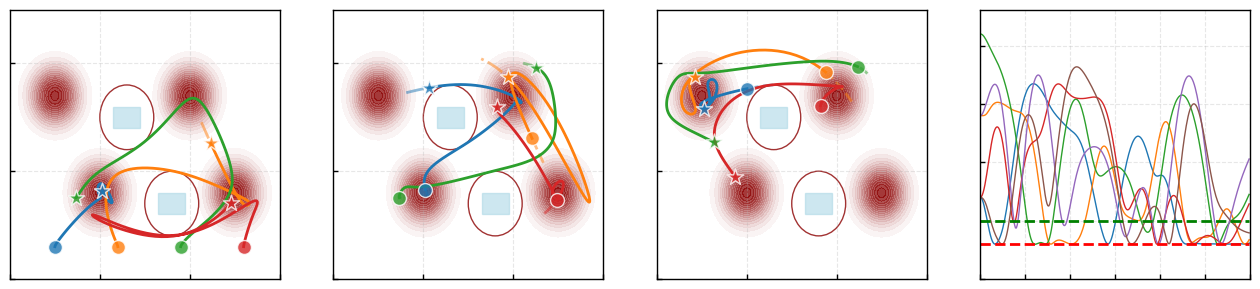

In [8]:
from utils.plot_utils import plot_trajs
import matplotlib.pyplot as plt

our_traj = results["x_traj"]
infomap = make_infomap(11)
fig, axes = plt.subplots(1, 4, figsize=(16, 3.5))
plot_trajs(axes, our_traj, infomap)
